In [41]:
import torch
import random
import numpy as np
import argparse

import torch
from torch import Tensor
from torch_geometric.logging import init_wandb, log
from torch_geometric.datasets import Planetoid
from utils import train, test, non_smooth_label_metric, label_difference, edgeindex2adj
from models import GCN, GAT, LP
import torch.nn.functional as F
import multiprocessing as mp


In [2]:
citeseer = Planetoid(root='.', name='Citeseer')
cora = Planetoid(root='.', name='Cora')
pubmed = Planetoid(root='.', name='Pubmed')
torch.use_deterministic_algorithms(True)

In [11]:
k = 5
seeds = [1234, 42, 2021]
seeds = [1234]
lr = 0.02
epochs = 200

GAT/GCN

In [4]:
# dataset = citeseer
# model = GCN(dataset.num_features, 16, dataset.num_classes)

dataset = cora
model = GCN(dataset.num_features, 16, dataset.num_classes)

# dataset = pubmed
# model = GCN(dataset.num_features, 16, dataset.num_classes)

# dataset = citeseer
# model = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)

# dataset = cora
# model = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)

# dataset = pubmed
# model = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)

In [5]:
torch.manual_seed(0)
data = dataset[0]
for c in data.y.unique():
    idx = ((data.y == c) & data.train_mask).nonzero(as_tuple=False).view(-1)
    idx = idx[torch.randperm(idx.size(0))]
    idx = idx[k:]
    data.train_mask[idx] = False

In [6]:
from models import AdaptiveLP
lp = AdaptiveLP(num_layers=8, yshape=dataset[0].y.shape[0], edge_dim=dataset.edge_index.shape[1])

In [7]:
pred = model(data.x, data.edge_index)

In [12]:
av_val_acc = av_test_acc = 0
state_dict_model = model.state_dict().copy()
state_dict_lp = lp.state_dict().copy()

for seed in seeds:
    print("RUNNING FOR SEED =", seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    model.load_state_dict(state_dict_model)
    lp.load_state_dict(state_dict_lp)
    
    optimizer = torch.optim.Adam(list(model.parameters()) + list(lp.parameters()), lr=lr, weight_decay=5e-4)

    best_val_acc = final_test_acc = 0
    for epoch in range(1, 200):
        model.train()
        lp.train()
        optimizer.zero_grad()
        
        out_model = model(data.x, data.edge_index)
        out_lp = lp(data)
        
        loss_model = F.cross_entropy(out_model[data.train_mask], data.y[data.train_mask])
        # loss_lp = (out_lp[data.train_mask] - data.y[data.train_mask]).pow(2).mean()
        loss_lp = F.cross_entropy(out_lp[data.train_mask], data.y[data.train_mask])
        ##########################################
        # sample some nodes from the unlabelled set
        unlab_mask = ~data.train_mask & ~data.val_mask & ~data.test_mask
        unlab_idx = unlab_mask.nonzero(as_tuple=False).view(-1)
        sample_unlab_idx = unlab_idx[torch.rand(unlab_idx.shape[0]) < 0.005]
        sample_unlab_mask = torch.zeros(unlab_mask.shape[0], dtype=torch.bool)
        sample_unlab_mask[sample_unlab_idx] = True
        
        # loss_unsup = F.cross_entropy(out_model[sample_unlab_mask], out_lp[sample_unlab_mask].argmax(dim=1))
        loss_unsup = F.cross_entropy(out_lp[sample_unlab_mask], out_model[sample_unlab_mask].argmax(dim=1))
        ##########################################
        # print(loss_model, loss_lp, loss_unsup)
        loss = loss_model + 2 * loss_lp + loss_unsup
        loss.backward()
        optimizer.step()
        
        train_acc, val_acc, tmp_test_acc = test(model, data)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        if epoch % 25 == 0:
            log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-2)
    for epoch in range(1, 200):
        loss = train(model, data, optimizer, loss='cross_entropy')
        train_acc, val_acc, tmp_test_acc = test(model, data)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        if epoch % 25 == 0:
            log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    
    print(f'Best Val Acc: {best_val_acc:.4f}', f'Test Acc: {test_acc:.4f}')
    av_val_acc += best_val_acc
    av_test_acc += test_acc
    
print(f'Average Val Acc / Average Test Acc: {av_val_acc / len(seeds):.4f} / {av_test_acc / len(seeds):.4f}')

RUNNING FOR SEED = 1234
Epoch: 025, Loss: 5.158029556274414, Train: 1.0000, Val: 0.5820, Test: 0.6400
Epoch: 050, Loss: 4.734297752380371, Train: 1.0000, Val: 0.6320, Test: 0.6530
Epoch: 075, Loss: 4.425845146179199, Train: 1.0000, Val: 0.6760, Test: 0.6930
Epoch: 100, Loss: 4.202141284942627, Train: 1.0000, Val: 0.6900, Test: 0.7130
Epoch: 125, Loss: 4.252775192260742, Train: 1.0000, Val: 0.6960, Test: 0.7200
Epoch: 150, Loss: 4.005704879760742, Train: 1.0000, Val: 0.6980, Test: 0.7200
Epoch: 175, Loss: 3.8928308486938477, Train: 1.0000, Val: 0.6960, Test: 0.7200
Epoch: 025, Loss: 0.3523871600627899, Train: 1.0000, Val: 0.6780, Test: 0.7160
Epoch: 050, Loss: 0.4365027844905853, Train: 1.0000, Val: 0.6900, Test: 0.7160
Epoch: 075, Loss: 0.4390605688095093, Train: 1.0000, Val: 0.6880, Test: 0.7160
Epoch: 100, Loss: 0.4375806450843811, Train: 1.0000, Val: 0.6880, Test: 0.7160
Epoch: 125, Loss: 0.4386460781097412, Train: 1.0000, Val: 0.6860, Test: 0.7160
Epoch: 150, Loss: 0.43763235211372

In [13]:
data = dataset[0]
preds = model(data.x, data.edge_index).argmax(dim=1)
non_smooth_label_metric(dataset, preds)

0.074

In [9]:
label_difference(model, dataset)

array([0.18843798, 0.17325692, 0.15899138, 0.18785147, 0.17619321,
       0.18405031, 0.209572  ])

In [17]:
zc

tensor([0.2159, 0.3421, 0.1546, 0.1988, 0.1901, 0.8992, 0.2700, 0.2148, 0.2608,
        0.4551, 0.2628, 0.3299, 0.6292, 0.2273, 0.2192, 0.3877],
       grad_fn=<MeanBackward1>)

In [19]:
zv.shape

torch.Size([180, 16])

In [15]:
C = dataset.num_classes
label_diff = np.zeros(C)
features = model.features
for c in range(C):
    num_nodes = data.y[data.y==c].shape[0]

    zc = features[data.y==c].mean(dim=0)
    zv = features[data.y==c]
    label_diff[c] = (torch.norm(zv-zc, dim=1).sum()/num_nodes).item()

In [24]:
torch.linalg.norm(zv-zc, dim=1, ord=2).sum()/num_nodes

tensor(0.6797, grad_fn=<DivBackward0>)

In [25]:
label_diff.mean()

0.6789641550609044

In [14]:
label_difference(model, dataset)

array([0.68557459, 0.65269798, 0.64193636, 0.67578918, 0.67316121,
       0.74384373, 0.67974603])

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-2)
for epoch in range(1, 100):
    loss = train(model, data, optimizer, loss='cross_entropy')
    train_acc, val_acc, tmp_test_acc = test(model, data)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    if epoch % 25 == 0:
        log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)

print(f'Best Val Acc: {best_val_acc:.4f}', f'Test Acc: {test_acc:.4f}')


NameError: name 'best_val_acc' is not defined

In [1]:
dataset.name

NameError: name 'dataset' is not defined

In [ ]:
unlab_mask = ~data.train_mask & ~data.val_mask & ~data.test_mask
unlab_idx = unlab_mask.nonzero(as_tuple=False).view(-1)
sample_unlab_idx = unlab_idx[torch.rand(unlab_idx.shape[0]) < 0.005]
sample_unlab_mask = torch.zeros(unlab_mask.shape[0], dtype=torch.bool)
sample_unlab_mask[sample_unlab_idx] = True
sample_unlab_mask.shape, sample_unlab_mask.sum()

(torch.Size([3327]), tensor(10))

0.154

# Error analysis

In [33]:
# TSNE plot
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [36]:
dataset = cora
data = dataset[0]


In [189]:
model_GCN = GCN(dataset.num_features, 16, dataset.num_classes)
model_lpa_GCN = GCN(dataset.num_features, 16, dataset.num_classes)
model_GAT = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)
model_lpa_GAT = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)
model_ls_GAT = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)

In [190]:
model_GAT.load_state_dict(torch.load('./models/Cora_GAT_2.pt'))
model_lpa_GAT.load_state_dict(torch.load('./models/Cora_GAT_LPA_2.pt'))
model_ls_GAT.load_state_dict(torch.load('./models/Cora_GAT_LS_2.pt'))
# model_GCN.load_state_dict(torch.load('./models/Citeseer_GCN_10.pt'))
# model_lpa_GCN.load_state_dict(torch.load('./models/Citeseer_GCN_LPA_10.pt'))

<All keys matched successfully>

In [82]:
preds = model(data.x, data.edge_index).argmax(dim=1)

In [71]:
non_label_smooth_node_counts = 0
total_nodes = 0
non_label_smooth_nodes = []
n = data.x.shape[0]
adj = edgeindex2adj(data.edge_index, n)
counts = torch.zeros((n, dataset.num_classes))
for edge in data.edge_index.T:
    counts[edge[0]][data.y[edge[1]]] +=1
for i in range(n):
    if data.val_mask[i]:
        if preds[i]!=data.y[i]:
            if counts[i][data.y[i]] == adj[i].sum() and adj[i].sum() > 1:
                non_label_smooth_node_counts +=1
                non_label_smooth_nodes.append(i)
        total_nodes +=1


In [72]:
len(non_label_smooth_nodes)


95

In [73]:
non_label_smooth_nodes = non_label_smooth_nodes[:25]

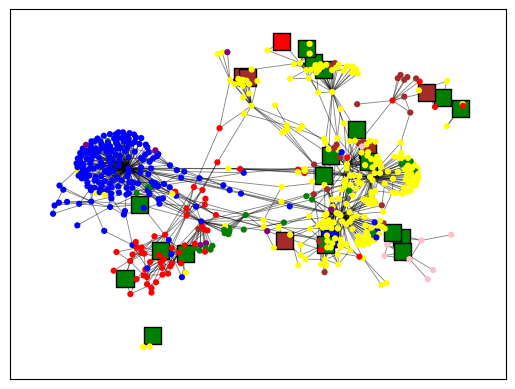

In [74]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

G.add_nodes_from(range(data.num_nodes))

edge_index = data.edge_index.t().tolist()

G.add_edges_from(edge_index)

node_labels = []
level_1_nodes = []
for i in non_label_smooth_nodes:
    for j in G.neighbors(i):
        level_1_nodes.append(j)
for i in level_1_nodes:
    for j in G.neighbors(i):
        node_labels.append(j)
node_labels = list(set(node_labels + level_1_nodes + non_label_smooth_nodes))
new_G = nx.Graph()
new_G.add_nodes_from(node_labels)

new_edge_index = []
for i in node_labels:
    for j in G.neighbors(i):
        if j in node_labels:
            new_edge_index.append([i,j])
new_G.add_edges_from(new_edge_index)


# Get node labels
# node_labels = data.y.tolist()

# Set node color by labels
color_map = ["red", "green", "blue", "yellow", "brown", "purple", "pink", "orange", "grey"]
node_color = [color_map[data.y[label]] if label not in non_label_smooth_nodes else color_map[preds[label]] for label in node_labels]
node_sizes = [100 if label in non_label_smooth_nodes else 20 for label in node_labels]
pos = nx.spring_layout(new_G, k=0.1)
highlight_border_color = 'black'
node_border_color = [highlight_border_color if label in non_label_smooth_nodes else 'none' for label in node_labels]
node_border_width = [10 if label in non_label_smooth_nodes else 0 for label in node_labels]
node_shapes = ['s' if label in non_label_smooth_nodes else 'o' for label in node_labels]
# Draw graph with node color and smaller size
# nx.draw(new_G, pos = pos, node_color=node_color, node_size=node_sizes, width=0.6, edgecolors = node_border_color, node_shape=node_shape, linewidths=node_border_width)
nx.draw_networkx_nodes(new_G, pos=pos, nodelist=non_label_smooth_nodes, node_color = [color_map[preds[label]] for label in non_label_smooth_nodes], node_size=150, node_shape='s', linewidths=1, edgecolors='black')
nx.draw_networkx_nodes(new_G, pos = pos, nodelist = [label for label in node_labels if label not in non_label_smooth_nodes], node_color=[color_map[data.y[label]] for label in node_labels if label not in non_label_smooth_nodes], node_size=20, node_shape='o', linewidths=0)
nx.draw_networkx_edges(new_G, pos=pos, width=0.6, alpha=0.5)

plt.show()

In [75]:
G = nx.Graph()

G.add_nodes_from(range(data.num_nodes))

edge_index = data.edge_index.t().tolist()

G.add_edges_from(edge_index)

In [191]:
preds_gat = model_GAT(data.x, data.edge_index).argmax(dim=1)
preds_lpa_gat = model_lpa_GAT(data.x, data.edge_index).argmax(dim=1)
preds_gcn = model_GCN(data.x, data.edge_index).argmax(dim=1)
preds_lpa_gcn = model_lpa_GCN(data.x, data.edge_index).argmax(dim=1)
preds_ls_gat = model_ls_GAT(data.x, data.edge_index).argmax(dim=1)

In [192]:
n = data.x.shape[0]
misclaasified_homogeneity_gat = []
misclaasified_homogeneity_gcn = []
misclaasified_homogeneity_gat_lpa = []
misclaasified_homogeneity_gcn_lpa = []
misclaasified_homogeneity_gat_ls = []
for i in range(n):
    if data.val_mask[i]:
        if preds_gat[i]!=data.y[i]:
            num_homogenous = 0
            total_neighbors = 0
            for j in G.neighbors(i):
                total_neighbors +=1
                if data.y[j] == data.y[i]:
                    num_homogenous +=1
            misclaasified_homogeneity_gat.append(num_homogenous/total_neighbors)
        if preds_lpa_gat[i]!=data.y[i]:
            num_homogenous = 0
            total_neighbors = 0
            for j in G.neighbors(i):
                total_neighbors +=1
                if data.y[j] == data.y[i]:
                    num_homogenous +=1
            misclaasified_homogeneity_gat_lpa.append(num_homogenous/total_neighbors)
        if preds_gcn[i]!=data.y[i]:
            num_homogenous = 0
            total_neighbors = 0
            for j in G.neighbors(i):
                total_neighbors +=1
                if data.y[j] == data.y[i]:
                    num_homogenous +=1
            misclaasified_homogeneity_gcn.append(num_homogenous/total_neighbors)
        if preds_lpa_gcn[i]!=data.y[i]:
            num_homogenous = 0
            total_neighbors = 0
            for j in G.neighbors(i):
                total_neighbors +=1
                if data.y[j] == data.y[i]:
                    num_homogenous +=1
            misclaasified_homogeneity_gcn_lpa.append(num_homogenous/total_neighbors)
    
        if preds_ls_gat[i]!=data.y[i]:
            num_homogenous = 0
            total_neighbors = 0
            for j in G.neighbors(i):
                total_neighbors +=1
                if data.y[j] == data.y[i]:
                    num_homogenous +=1
            misclaasified_homogeneity_gat_ls.append(num_homogenous/total_neighbors)
    

Text(0.5, 0, 'Homogeneity of misclassified nodes')

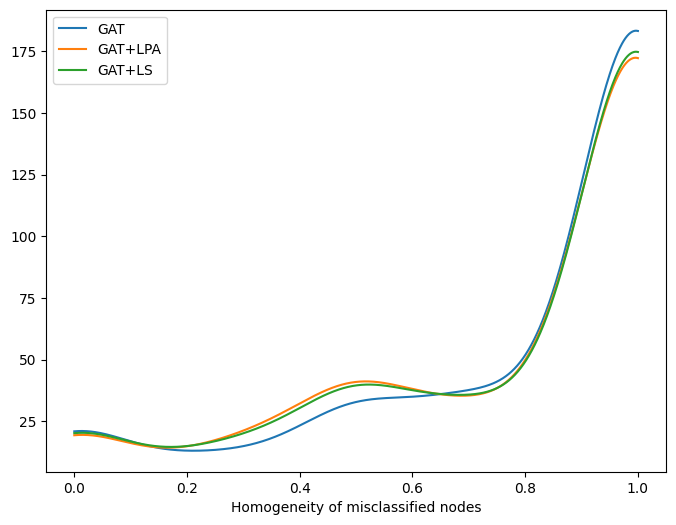

In [193]:
from scipy import stats
bins = np.arange(10)

xx = np.linspace(0, 1, 1000)
fig, ax = plt.subplots(figsize=(8,6))
# ax.hist(misclaasified_homogeneity, density=True, alpha=0.3)
kde = stats.gaussian_kde(misclaasified_homogeneity_gat)
ax.plot(xx, kde(xx)*70, label="GAT")
kde = stats.gaussian_kde(misclaasified_homogeneity_gat_lpa)
# ax.hist(misclaasified_homogeneity_lpa, density=True, alpha=0.3)
ax.plot(xx, kde(xx)*70, label="GAT+LPA")

kde = stats.gaussian_kde(misclaasified_homogeneity_gat_ls)
# ax.hist(misclaasified_homogeneity_lpa, density=True, alpha=0.3)
ax.plot(xx, kde(xx)*70, label="GAT+LS")

kde = stats.gaussian_kde(misclaasified_homogeneity_gcn)
# ax.plot(xx, kde(xx), label="GCN")
kde = stats.gaussian_kde(misclaasified_homogeneity_gcn_lpa)
# ax.hist(misclaasified_homogeneity_lpa, density=True, alpha=0.3)
# ax.plot(xx, kde(xx), label="GCN+LPA")
ax.legend()
ax.set_xlabel("Homogeneity of misclassified nodes")



In [127]:
plt.show()

(array([0.95238095, 0.10582011, 0.31746032, 0.42328042, 0.21164021,
        1.32275132, 0.63492063, 0.37037037, 0.47619048, 5.18518519]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

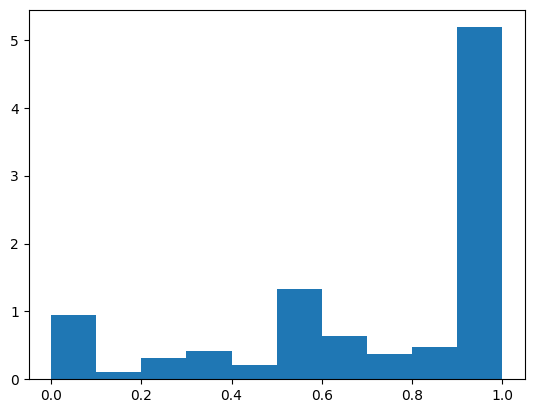

In [87]:
plt.hist(misclaasified_homogeneity, density=True)

In [78]:
model = GCN(dataset.num_features, 16, dataset.num_classes)

# Metrics

label_difference

In [ ]:
model_GAT

In [167]:
gat_diff = label_difference(model_GAT, cora)
gat_lpa_diff = label_difference(model_lpa_GAT, cora)

In [171]:
gat_diff

0.6581149356705802

In [170]:
gat_lpa_diff

0.6809568405151367

## MHNN

In [172]:
cora_gat = [0.276,0.258,0.134,0.06,0.038]
cora_gat_lpa = [0.23,0.132,0.09,0.058,0.036]
cora_gcn = [0.324,0.16,0.074,0.054,0.04]
cora_gcn_lpa = [0.322,0.156,0.074,0.056,0.04]
cora_gat_ls = [0.238,0.188,0.078,0.066,0.04]
cora_gcn_ls = [0.226,0.172,0.108,0.066,0.044]


In [173]:
x = ["5%", "10%", "25%", "50%", "100%"]

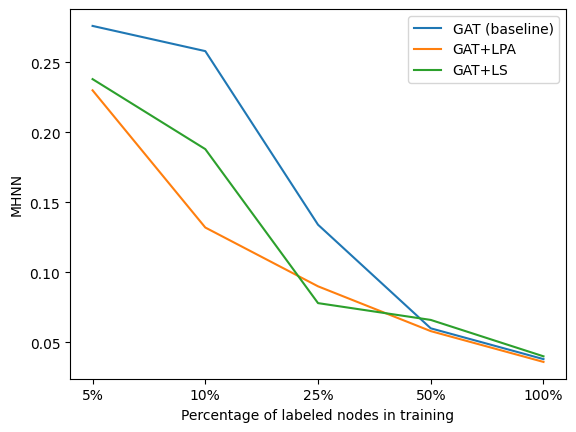

In [176]:
plt.plot(x,cora_gat, label="GAT (baseline)")
plt.plot(x,cora_gat_lpa, label="GAT+LPA")
plt.plot(x,cora_gat_ls, label="GAT+LS")

plt.xlabel("Percentage of labeled nodes in training")
plt.ylabel("MHNN")
plt.legend()

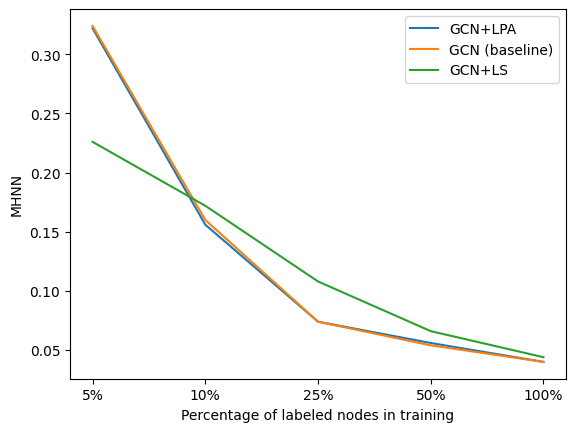

In [177]:
plt.plot(x,cora_gcn_lpa, label="GCN+LPA")
plt.plot(x,cora_gcn, label="GCN (baseline)")
plt.plot(x,cora_gcn_ls, label="GCN+LS")

plt.xlabel("Percentage of labeled nodes in training")
plt.ylabel("MHNN")
plt.legend()

In [218]:

def label_difference(model, dataset):
    model.eval()
    data = dataset[0]
    pred = model(data.x, data.edge_index).argmax(dim=-1)
    # label diff = 1/V * sum_{v in V} |z_v - z_c|
    # z_c is readout(intermediate feature) of nodes with class c
    # z_v is readout(intermediate feature) of node v
    # V is the set of nodes with class c

    C = dataset.num_classes
    label_diff = np.zeros(C)
    features = model.features
    for c in range(C):
        num_nodes = pred[(pred==c) & data.val_mask].shape[0]
        if num_nodes == 0:
            return 0
        zc = features[(pred==c) & data.val_mask].mean(dim=0)
        zv = features[(pred==c) & data.val_mask]
        print(num_nodes)
        label_diff[c] = (torch.linalg.norm(zv-zc, dim=1, ord=2).sum()/num_nodes).item()
    return label_diff

In [219]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

GAT 1
48
282
47
14
52
46
11
GAT_LPA 1
89
135
131
35
47
52
11
GAT_LS 1
92
63
220
5
58
56
6
GAT 2
66
175
73
40
89
46
11
GAT_LPA 2
119
49
104
66
119
32
11
GAT_LS 2
109
67
138
40
94
43
9
GAT 5
101
70
66
98
97
48
20
GAT_LPA 5
119
58
74
81
98
55
15
GAT_LS 5
98
48
84
80
128
43
19
GAT 10
60
50
85
139
81
66
19
GAT_LPA 10
90
49
82
109
91
59
20
GAT_LS 10
71
50
93
125
78
62
21
GAT 20
75
43
84
121
95
48
34
GAT_LPA 20
90
47
80
115
93
46
29
GAT_LS 20
95
46
88
118
73
49
31


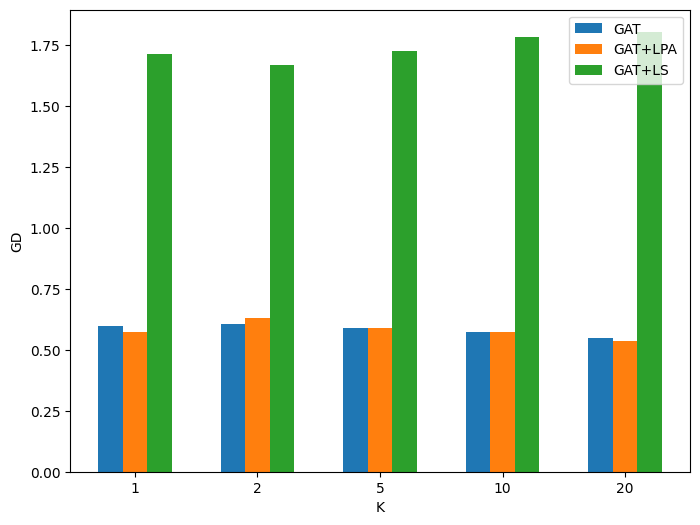

In [237]:
ks = [1,2,5,10,20]
data = []
for k in ks:
    ls = []
    # for model_type in ["GCN", "GCN_LPA"]:
    for model_type in ["GAT", "GAT_LPA", "GAT_LS"]:
        model = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)
        # model = GCN(dataset.num_features, 16, dataset.num_classes)
        model.load_state_dict(torch.load(f"models/cora_{model_type}_{str(k)}.pt"))
        print(model_type, k)
        ls.append(label_difference(model, cora).mean())
    data.append(ls)

data = np.array(data)
# Plot bar chart
x = np.arange(len(ks))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width, data[:,0], width, label='GAT')
rects2 = ax.bar(x, data[:,1], width, label='GAT+LPA')
rects3 = ax.bar(x + width, data[:,2], width, label='GAT+LS')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('GD')
ax.set_xlabel('K')
ax.set_xticks(x)
ax.set_xticklabels(ks)
ax.legend()




In [238]:
from sklearn.metrics.pairwise import cosine_similarity
def MAD(model, dataset):
    model.eval()
    data = dataset[0]
    pred = model(data.x, data.edge_index).argmax(dim=-1)


    C = dataset.num_classes
    features = model.features.detach().numpy()
    mad_val = 0
    for c in range(C):
        features_c = features[(pred==c) & data.val_mask]
    
        mad = cosine_similarity(features_c, features_c).mean()
        mad_val += mad

    return mad_val/C
    

In [239]:
dataset = cora

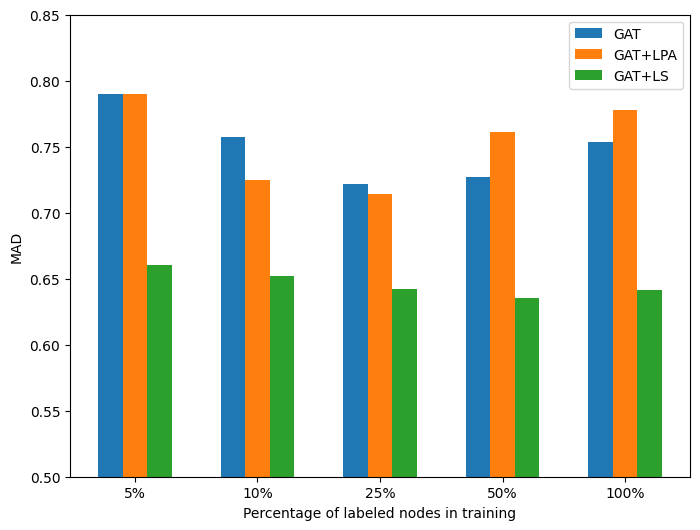

In [244]:
ks = [1,2,5,10,20]
percentages = ["5%", "10%", "25%", "50%", "100%"]
data = []
for k in ks:
    ls = []
    # for model_type in ["GCN", "GCN_LPA"]:
    for model_type in ["GAT", "GAT_LPA", "GAT_LS"]:
        model = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)
        # model = GCN(dataset.num_features, 16, dataset.num_classes)
        model.load_state_dict(torch.load(f"models/Cora_{model_type}_{str(k)}.pt"))
        ls.append(MAD(model, cora))
    data.append(ls)

data = np.array(data)
# Plot bar chart
x = np.arange(len(ks))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width, data[:,0], width, label='GAT')
rects2 = ax.bar(x, data[:,1], width, label='GAT+LPA')
rects3 = ax.bar(x + width, data[:,2], width, label='GAT+LS')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAD')
ax.set_xlabel('Percentage of labeled nodes in training')
ax.set_ylim(0.5,0.85)
ax.set_xticks(x)
ax.set_xticklabels(percentages)
ax.legend()




## Correlation

In [256]:
model = LP(num_layers=16, alpha=0.99)
preds_lp = model.train(dataset).argmax(dim=-1)
train_acc, val_acc, tmp_test_acc = model.test()

In [257]:
train_acc, val_acc, tmp_test_acc

(1.0, 0.548, 0.559)

In [258]:
preds_lp.shape

torch.Size([2708])

In [269]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [289]:
misclass_lp = (preds_lp != dataset[0].y).detach().numpy().astype(int)
misclass_gat = (preds_gat != dataset[0].y).detach().numpy().astype(int)
misclass_gat_lp = (preds_lpa_gat != dataset[0].y).detach().numpy().astype(int)
misclass_gat_ls = (preds_ls_gat != dataset[0].y).detach().numpy().astype(int)

In [290]:
misclass_lp.sum(), misclass_gat.sum(), misclass_gat_lp.sum(),misclass_gat_ls.sum(), len(misclass_gat)

(1156, 1612, 1565, 1581, 2708)

In [286]:
np.dot(misclass_lp, misclass_gat)

922

In [287]:
corr_gat_gatlpa = np.dot(misclass_gat, misclass_gat_lp)/len(misclass_gat)
corr_gat_lp = np.dot(misclass_gat, misclass_lp)/len(misclass_gat)
corr_gatlpa_lp = np.dot(misclass_gat_lp, misclass_lp)/len(misclass_gat)



In [311]:
for i in [misclass_lp, misclass_gat, misclass_gat_lp, misclass_gat_ls]:
    for j in [misclass_lp, misclass_gat, misclass_gat_lp, misclass_gat_ls]:
        print(f"{np.dot(i,j)/(np.linalg.norm(i)*np.linalg.norm(j)):.2f}", end = " & ")
    print("\\\\")

1.00 & 0.68 & 0.67 & 0.69 & \\
0.68 & 1.00 & 0.73 & 0.74 & \\
0.67 & 0.73 & 1.00 & 0.73 & \\
0.69 & 0.74 & 0.73 & 1.00 & \\


In [265]:
(preds_lp!=preds_gat).sum(),(preds_lp == dataset[0].y).sum(), preds.shape[0]

(tensor(1572), tensor(1552), 2708)

In [263]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [295]:
import networkx as nx


In [297]:
dataset[0].num_nodes

2708

In [ ]:
import random

In [ ]:
model

In [341]:
tsne = TSNE(2)
features = model_GAT.features.detach().numpy()
# features = dataset[0].x
features_embedded = tsne.fit_transform(features)
features_embedded.shape

C:\Users\kousi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kousi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2708, 2)

In [342]:
model_GAT = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)

In [343]:
model_GAT.load_state_dict(torch.load("models/CORA_GAT_20.pt"))


<All keys matched successfully>

In [344]:
model_GAT

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)

In [345]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [346]:
preds_gat = model_GAT(dataset[0].x, dataset[0].edge_index).argmax(dim=-1)

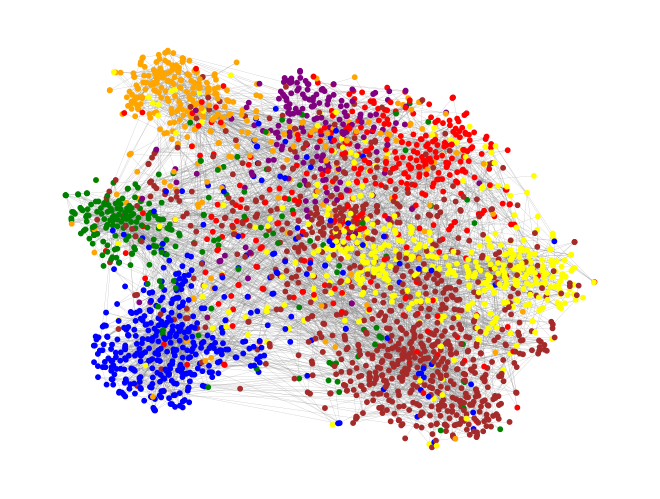

In [350]:
data = dataset[0]
preds = preds_gat
num_sample_nodes = 100
sample_nodes = random.sample(range(data.num_nodes), num_sample_nodes)


G = nx.Graph()

G.add_nodes_from(range(data.num_nodes))

edge_index = data.edge_index.t().tolist()

G.add_edges_from(edge_index)
new_G = G.subgraph(sample_nodes)

color_map = ["red", "green"]
node_color = [color_map[int(data.y[label]==preds_gat[label])] for label in range(data.num_nodes)]

pos = {}
for i, node in enumerate(G.nodes()):
    pos[node] = features_embedded[i]

# Draw graph with node color and smaller size
nx.draw(G, pos = pos, node_color=node_color, node_size = 10, width=0.1)


plt.show()

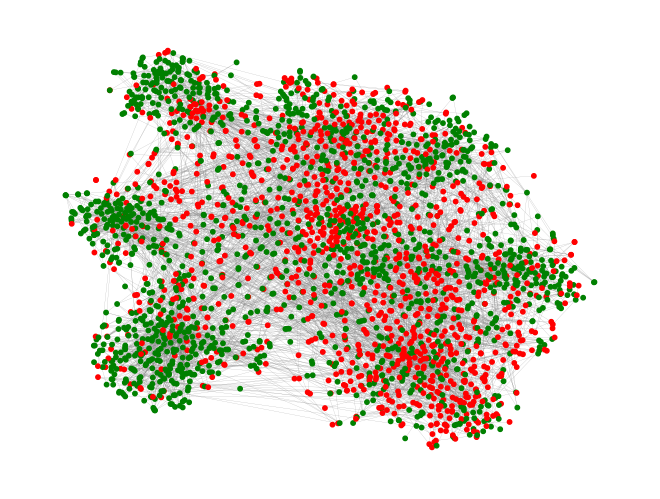

In [ ]:
x = 1.00 & 0.68 & 0.67 & 0.69 & \\
0.68 & 1.00 & 0.73 & 0.74 & \\
0.67 & 0.73 & 1.00 & 0.73 & \\
0.69 & 0.74 & 0.73 & 1.00 &

In [ ]:
1.00,0.68 , 0.67 , 0.69]
0.68,1.00 , 0.73 , 0.74] 
0.67,0.73 , 1.00 , 0.73]
0.69,0.74 , 0.73 , 1.00]